# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


We will import the following libraries for the lab


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

This function is to plot the confusion matrix.


In [2]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe


Load the data


In [13]:
import hopsworks as hw
#close()
project = hw.login()

fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/542868
Connected. Call `.close()` to terminate connection gracefully.


In [14]:
fg = fs.get_feature_group('rocket_launch', version=1)
training_set = fg.select_except(['flightnumber'])
#data = pd.read_csv("./../Data/dataset_part_3.csv")

In [15]:
training_set.show(10)

Finished: Reading data from Hopsworks, using Hive (2.15s) 


payloadmass  flights  gridfins  reused  legs  block  reusedcount  \
0       2910.0      1.0       1.0     0.0   1.0    4.0          1.0   
1       2296.0      1.0       0.0     0.0   1.0    1.0          0.0   
2       9600.0      1.0       1.0     0.0   1.0    5.0          4.0   
3       3100.0      1.0       1.0     0.0   1.0    2.0          1.0   
4      15600.0      5.0       1.0     1.0   1.0    5.0          4.0   
5        525.0      1.0       0.0     0.0   0.0    1.0          0.0   
6       2490.0      1.0       1.0     0.0   1.0    3.0          1.0   
7      15600.0      2.0       1.0     1.0   1.0    5.0         12.0   
8      15600.0      4.0       1.0     1.0   1.0    5.0          9.0   
9        553.0      1.0       1.0     0.0   1.0    1.0          0.0   

   orbit_es_l1  orbit_geo  orbit_gto  ...  orbit_leo  orbit_meo  orbit_po  \
0          0.0        0.0        0.0  ...        0.0        0.0       0.0   
1          0.0        0.0        0.0  ...        0.0        0.0       0.0   
2          0.0        0.0        0.0  ...        0.0        0.0       1.0   
3          0.0        0.0        1.0  ...        0.0        0.0       0.0   
4          0.0        0.0        0.0  ...        0.0        0.0       0.0   
5          0.0        0.0        0.0  ...        1.0        0.0       0.0   
6          0.0        0.0        0.0  ...        0.0        0.0       0.0   
7          0.0        0.0        0.0  ...        0.0        0.0       0.0   
8          0.0        0.0        0.0  ...        0.0        0.0       0.0   
9          0.0        0.0        0.0  ...        0.0        0.0       1.0   

   orbit_so  orbit_sso  orbit_vleo  launchsite_ccsfs_slc_40  \
0       0.0        0.0         0.0                      0.0   
1       0.0        0.0         0.0                      1.0   
2       0.0        0.0         0.0                      0.0   
3       0.0        0.0         0.0                      1.0   
4       0.0        0.0         1.0                      0.0   
5       0.0        0.0         0.0                      1.0   
6       0.0        0.0         0.0                      0.0   
7       0.0        0.0         1.0                      0.0   
8       0.0        0.0         1.0                      1.0   
9       0.0        0.0         0.0                      0.0   

   launchsite_ksc_lc_39a  launchsite_vafb_slc_4e  predictions  
0                    1.0                     0.0          1.0  
1                    0.0                     0.0          1.0  
2                    0.0                     1.0          1.0  
3                    0.0                     0.0          1.0  
4                    1.0                     0.0          0.0  
5                    0.0                     0.0          0.0  
6                    1.0                     0.0          1.0  
7                    1.0                     0.0          1.0  
8                    0.0                     0.0          1.0  
9                    0.0                     1.0          0.0  

[10 rows x 22 columns]

## Normalization of data

In [16]:
standard_transformation = fs.get_transformation_function(name="standard_scaler")
min_max_transformation = fs.get_transformation_function(name="min_max_scaler")
transformation_function = {}

In [17]:
transformation_function = {
    "payloadmass" : standard_transformation,
    "flights" : min_max_transformation,
    "block" : min_max_transformation,
    "reusedcount" : min_max_transformation
}


## Create feature view

In [18]:
feature_view = fs.get_or_create_feature_view(
    name= "rocket_launch_view",
    description= "feature view fro booster landing success prediction.",
    query= training_set,
    labels= ["predictions"],
    transformation_functions= transformation_function,
    version= 1
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/542868/fs/538691/fv/rocket_launch_view/version/1


In [59]:
#Y = data['predictions'].to_numpy()

In [37]:
# students get this 
# transform = preprocessing.StandardScaler()
# transform.fit(X)
# X = transform.transform(X)
# X

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## Train Validation Test split


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [19]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

X_train, X_val, X_test, y_train, y_val, y_test = feature_view.train_validation_test_split(
    validation_size= 0.2,
    test_size= 0.1
)

Finished: Reading data from Hopsworks, using Hive (3.00s) 


In [20]:
X_train.head(10)

payloadmass  flights  gridfins  reused  legs  block  reusedcount  \
1     -0.787924      0.0       0.0     0.0   1.0    0.0     0.000000   
2      0.722295      0.0       1.0     0.0   1.0    1.0     0.307692   
4      1.962890      0.8       1.0     1.0   1.0    1.0     0.307692   
5     -1.154106      0.0       0.0     0.0   0.0    0.0     0.000000   
7      1.962890      0.2       1.0     1.0   1.0    1.0     0.923077   
9     -1.148317      0.0       1.0     0.0   1.0    0.0     0.000000   
10    -0.007589      0.0       0.0     0.0   0.0    0.5     0.000000   
12     1.962890      0.4       1.0     1.0   1.0    1.0     0.384615   
14     0.081320      0.4       0.0     1.0   0.0    1.0     0.153846   
15    -0.435595      0.4       1.0     1.0   1.0    1.0     0.230769   

    orbit_es_l1  orbit_geo  orbit_gto  ...  orbit_iss  orbit_leo  orbit_meo  \
1           0.0        0.0        0.0  ...        1.0        0.0        0.0   
2           0.0        0.0        0.0  ...        0.0        0.0        0.0   
4           0.0        0.0        0.0  ...        0.0        0.0        0.0   
5           0.0        0.0        0.0  ...        0.0        1.0        0.0   
7           0.0        0.0        0.0  ...        0.0        0.0        0.0   
9           0.0        0.0        0.0  ...        0.0        0.0        0.0   
10          0.0        0.0        1.0  ...        0.0        0.0        0.0   
12          0.0        0.0        0.0  ...        0.0        0.0        0.0   
14          0.0        0.0        1.0  ...        0.0        0.0        0.0   
15          0.0        0.0        0.0  ...        0.0        0.0        0.0   

    orbit_po  orbit_so  orbit_sso  orbit_vleo  launchsite_ccsfs_slc_40  \
1        0.0       0.0        0.0         0.0                      1.0   
2        1.0       0.0        0.0         0.0                      0.0   
4        0.0       0.0        0.0         1.0                      0.0   
5        0.0       0.0        0.0         0.0                      1.0   
7        0.0       0.0        0.0         1.0                      0.0   
9        1.0       0.0        0.0         0.0                      0.0   
10       0.0       0.0        0.0         0.0                      0.0   
12       0.0       0.0        0.0         1.0                      1.0   
14       0.0       0.0        0.0         0.0                      1.0   
15       0.0       0.0        1.0         0.0                      0.0   

    launchsite_ksc_lc_39a  launchsite_vafb_slc_4e  
1                     0.0                     0.0  
2                     0.0                     1.0  
4                     1.0                     0.0  
5                     0.0                     0.0  
7                     1.0                     0.0  
9                     0.0                     1.0  
10                    1.0                     0.0  
12                    0.0                     0.0  
14                    0.0                     0.0  
15                    0.0                     1.0  

[10 rows x 21 columns]

we can see we only have 18 test samples.


In [24]:
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

## Logistic reggression


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [22]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [27]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, param_grid=parameters, cv=10)
logreg_cv.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [28]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8285714285714285


## Confusion Matrix logistic reggression


Calculate the accuracy on the test data using the method <code>score</code>:


In [29]:
logreg_cv.score(X_test, y_test)

0.9

Lets look at the confusion matrix:


In [30]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## SVM


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [31]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [32]:
svm_cv = GridSearchCV(svm, param_grid=parameters, cv=10)
svm_cv.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [33]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'rbf'}
accuracy : 0.8452380952380952


## Confusion Matrix SVM


Calculate the accuracy on the test data using the method <code>score</code>:


In [34]:
svm_cv.score(X_test, y_test)

0.9

We can plot the confusion matrix


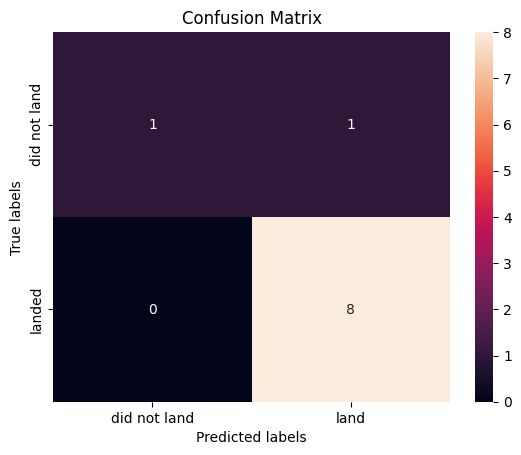

In [35]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)

## Decission Tree


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [36]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['sqrt', 'log2'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [37]:
tree_cv = GridSearchCV(tree, param_grid=parameters, cv=10)
tree_cv.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [38]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.9071428571428573


## Confusion Matrix Decission tree


///////////////////// Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [39]:
tree_cv.score(X_test, y_test)

0.7

////////////////// We can plot the confusion matrix


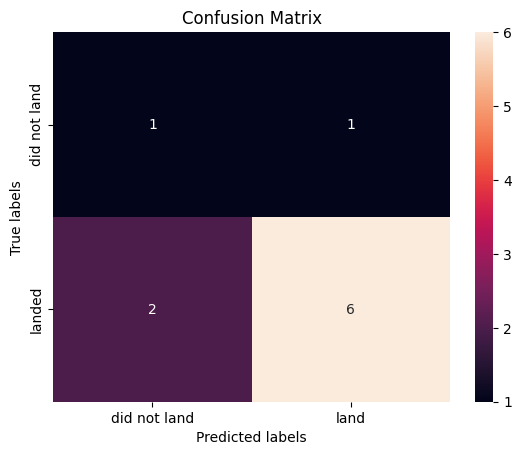

In [40]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)

## KNN


/////////////////////////////////// Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [41]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [42]:
knn_cv = GridSearchCV(KNN, param_grid=parameters, cv=10)
knn_cv.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [43]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2}
accuracy : 0.85


## Confusion Matrix KNNN


///////////////////////////// Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [44]:
knn_cv.score(X_test, y_test)

0.8

/////////////////////////////////////// We can plot the confusion matrix


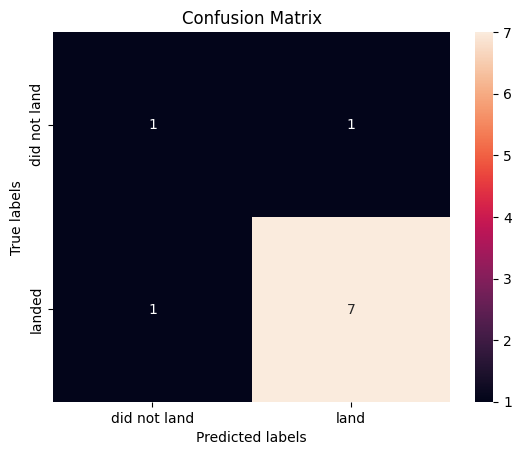

In [45]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)

## Create model registry and save models in the registry:


/////////////////////////////////// Lets create a model registry object

In [46]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


////////////////////////////////////////////// Create schema for input and out data format for the model. It is to make model registry understand what type of data is used in input and what is the output.

In [47]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)

model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()


{'input_schema': {'columnar_schema': [{'name': 'payloadmass',
    'type': 'float64'},
   {'name': 'flights', 'type': 'float64'},
   {'name': 'gridfins', 'type': 'float64'},
   {'name': 'reused', 'type': 'float64'},
   {'name': 'legs', 'type': 'float64'},
   {'name': 'block', 'type': 'float64'},
   {'name': 'reusedcount', 'type': 'float64'},
   {'name': 'orbit_es_l1', 'type': 'float64'},
   {'name': 'orbit_geo', 'type': 'float64'},
   {'name': 'orbit_gto', 'type': 'float64'},
   {'name': 'orbit_heo', 'type': 'float64'},
   {'name': 'orbit_iss', 'type': 'float64'},
   {'name': 'orbit_leo', 'type': 'float64'},
   {'name': 'orbit_meo', 'type': 'float64'},
   {'name': 'orbit_po', 'type': 'float64'},
   {'name': 'orbit_so', 'type': 'float64'},
   {'name': 'orbit_sso', 'type': 'float64'},
   {'name': 'orbit_vleo', 'type': 'float64'},
   {'name': 'launchsite_ccsfs_slc_40', 'type': 'float64'},
   {'name': 'launchsite_ksc_lc_39a', 'type': 'float64'},
   {'name': 'launchsite_vafb_slc_4e', 'type':

//////////////////////////////////// Now I need to create and save the models to pickle file.

In [48]:
import joblib

model_dir = "E:\\machine learning\\rocket_booster_Landing_prediction\\rocket_booster_landing_prediction\\Saved_models\\"

lr_pckl = model_dir + "lr.pkl"

svc_pckl = model_dir + "svc.pkl"

tree_pckl = model_dir + "tree.pkl"

knn_pckl = model_dir + "knn.pkl"

joblib.dump(logreg_cv.best_estimator_, lr_pckl)
joblib.dump(svm_cv.best_estimator_, svc_pckl)
joblib.dump(tree_cv.best_estimator_, tree_pckl)
joblib.dump(knn_cv.best_estimator_, knn_pckl)

['E:\\machine learning\\rocket_booster_Landing_prediction\\rocket_booster_landing_prediction\\Saved_models\\knn.pkl']

//////////////////////////// Now create save models in the model registry.

In [50]:
model_lr = mr.python.create_model(
    name= "lrmodel",
    description= "logistich reggression model",
    version= 1,
    input_example=X_train.sample(),
    model_schema= model_schema,
)
model_lr.save(lr_pckl)

model_svc = mr.python.create_model(
    name="svcmodel",
    description="svm classifier model",
    version= 1,
    input_example=X_train.sample(),
    model_schema= model_schema,
)
model_svc.save(svc_pckl)

Uploading model files (0 dirs, 0 files):  17%|███████▏                                   | 1/6 [00:00<00:02,  2.13it/s]
Uploading: 0.000%|                                                                   | 0/1663 elapsed<00:00 remaining<?
Uploading: 100.000%|██████████████████████████████████████████████████████████| 1663/1663 elapsed<00:01 remaining<00:00
Uploading input_example and model_schema:  33%|██████████████                            | 2/6 [00:02<00:05,  1.41s/it]
Uploading: 0.000%|                                                                    | 0/121 elapsed<00:00 remaining<?
Uploading: 100.000%|████████████████████████████████████████████████████████████| 121/121 elapsed<00:01 remaining<00:00

Uploading: 0.000%|                                                                   | 0/1798 elapsed<00:00 remaining<?
Uploading: 100.000%|██████████████████████████████████████████████████████████| 1798/1798 elapsed<00:01 remaining<00:00
Model export complete: 100%|███████████

Model created, explore it at https://c.app.hopsworks.ai:443/p/542868/models/lrmodel/1


Uploading model files (0 dirs, 0 files):  17%|███████▏                                   | 1/6 [00:00<00:01,  3.31it/s]
Uploading: 0.000%|                                                                  | 0/11339 elapsed<00:00 remaining<?
Uploading: 100.000%|████████████████████████████████████████████████████████| 11339/11339 elapsed<00:01 remaining<00:00
Uploading input_example and model_schema:  33%|██████████████                            | 2/6 [00:02<00:05,  1.31s/it]
Uploading: 0.000%|                                                                    | 0/122 elapsed<00:00 remaining<?
Uploading: 100.000%|████████████████████████████████████████████████████████████| 122/122 elapsed<00:01 remaining<00:00

Uploading: 0.000%|                                                                   | 0/1798 elapsed<00:00 remaining<?
Uploading: 100.000%|██████████████████████████████████████████████████████████| 1798/1798 elapsed<00:01 remaining<00:00
Model export complete: 100%|███████████

Model created, explore it at https://c.app.hopsworks.ai:443/p/542868/models/svcmodel/1


Model(name: 'svcmodel', version: 1)

In [51]:
model_svc = mr.python.create_model(
    name="knnmodel",
    description="knn classifier model",
    version= 1,
    input_example=X_train.sample(),
    model_schema= model_schema,
)
model_svc.save(knn_pckl)

model_svc = mr.python.create_model(
    name="treemodel",
    description="decision tree model",
    version= 1,
    input_example=X_train.sample(),
    model_schema= model_schema,
)
model_svc.save(tree_pckl)

Uploading model files (0 dirs, 0 files):  17%|███████▏                                   | 1/6 [00:00<00:02,  1.97it/s]
Uploading: 0.000%|                                                                  | 0/12371 elapsed<00:00 remaining<?
Uploading: 100.000%|████████████████████████████████████████████████████████| 12371/12371 elapsed<00:01 remaining<00:00
Uploading input_example and model_schema:  33%|██████████████                            | 2/6 [00:02<00:05,  1.42s/it]
Uploading: 0.000%|                                                                    | 0/135 elapsed<00:00 remaining<?
Uploading: 100.000%|████████████████████████████████████████████████████████████| 135/135 elapsed<00:01 remaining<00:00

Uploading: 0.000%|                                                                   | 0/1798 elapsed<00:00 remaining<?
Uploading: 100.000%|██████████████████████████████████████████████████████████| 1798/1798 elapsed<00:01 remaining<00:00
Model export complete: 100%|███████████

Model created, explore it at https://c.app.hopsworks.ai:443/p/542868/models/knnmodel/1


Uploading model files (0 dirs, 0 files):  17%|███████▏                                   | 1/6 [00:00<00:02,  1.97it/s]
Uploading: 0.000%|                                                                   | 0/4105 elapsed<00:00 remaining<?
Uploading: 100.000%|██████████████████████████████████████████████████████████| 4105/4105 elapsed<00:01 remaining<00:00
Uploading input_example and model_schema:  33%|██████████████                            | 2/6 [00:02<00:05,  1.46s/it]
Uploading: 0.000%|                                                                    | 0/135 elapsed<00:00 remaining<?
Uploading: 100.000%|████████████████████████████████████████████████████████████| 135/135 elapsed<00:01 remaining<00:00

Uploading: 0.000%|                                                                   | 0/1798 elapsed<00:00 remaining<?
Uploading: 100.000%|██████████████████████████████████████████████████████████| 1798/1798 elapsed<00:01 remaining<00:00
Model export complete: 100%|███████████

Model created, explore it at https://c.app.hopsworks.ai:443/p/542868/models/treemodel/1


Model(name: 'treemodel', version: 1)

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork865-2023-01-01)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
